In [5]:
from pyimagesearch import config
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os

In [6]:
def prepare_plot(origImage, origMask, predMask):
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

    #plot images
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)

    # set titles for subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")

    figure.tight_layout()
    figure.show()

In [7]:
def make_prediction(model, imagePath):
    model.eval()

    with torch.no_grad():
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype('float32') / 255.0

        image = cv2.resize(image, (config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDGH))
        orig = image.copy()

        filename = imagePath.split(os.path.sep)[-1]
        #print(imagePath.split(os.path.sep))  # ['dataset', 'train', 'images', 'b911d46acb.png']
        #print(filename)                      # filename: b911d46acb.png
        groundTruthPath = os.path.join(config.MASK_DATASET_PATH, filename)

        gtMask = cv2.imread(groundTruthPath, 0) # read image as grayscale!
        gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDGH))

        image = np.transpose(image, (2, 0, 1)) #change column order
        image = torch.Tensor(image)            
        image = torch.unsqueeze(image, 0)
        image = image.to(config.DEVICE)


        predMask = model(image).squeeze()
        #print(predMask.shape)
        predMask = torch.sigmoid(predMask) #scale 0~1
        predMask = predMask.cpu().numpy()  

        predMask = (predMask > config.THRESHOLD) * 255  #if value is bigger than threshold than 255 else 0
        predMask = predMask.astype(np.uint8)

        prepare_plot(orig, gtMask, predMask) # all feature shape is (128, 128, 128)

[INFO] loading up test image paths...
[INFO] load up model...
output/unet#0_cost:0.2682.pth


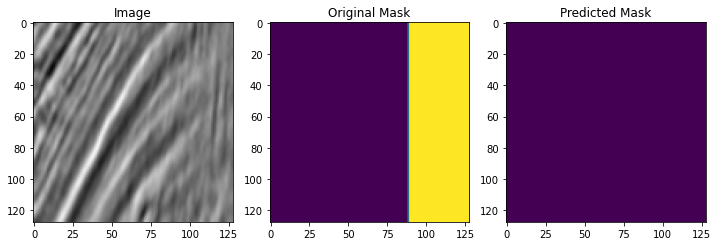

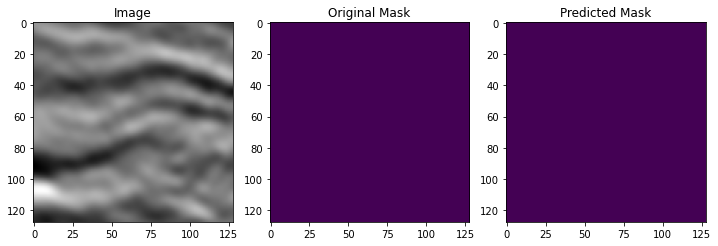

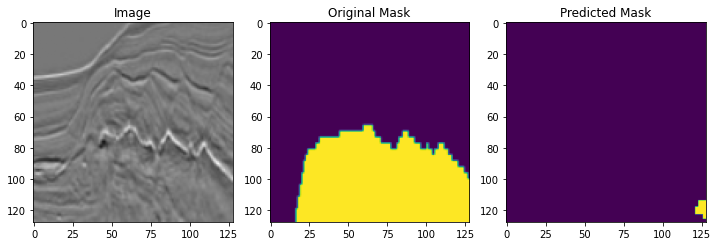

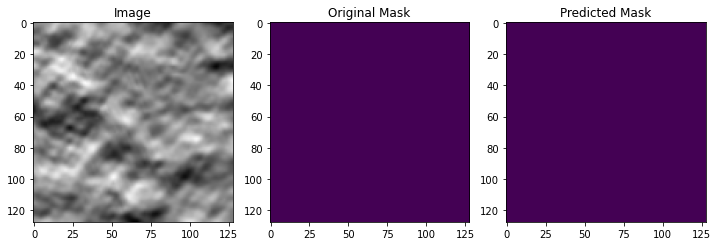

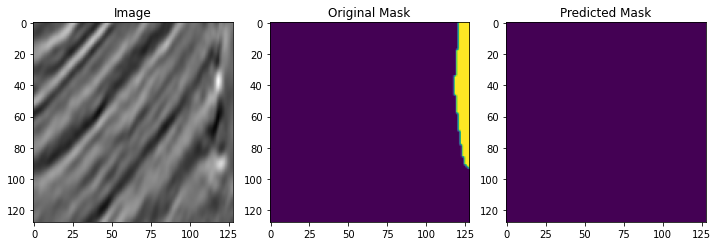

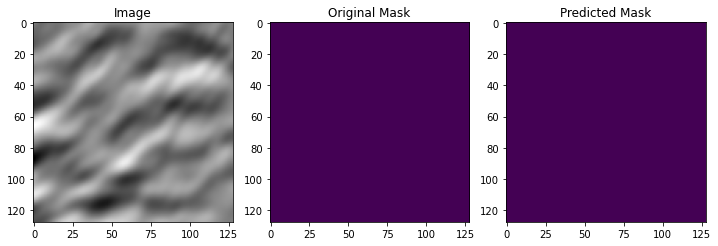

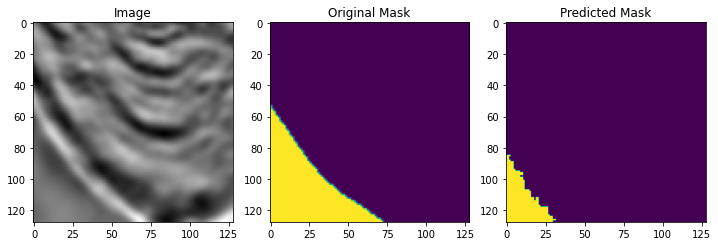

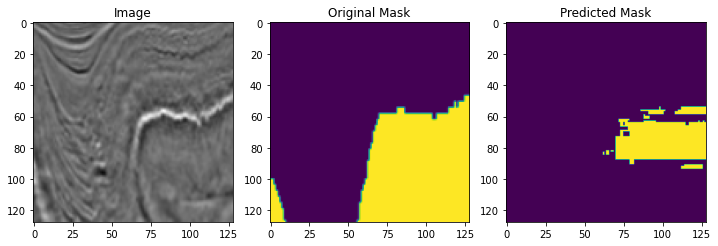

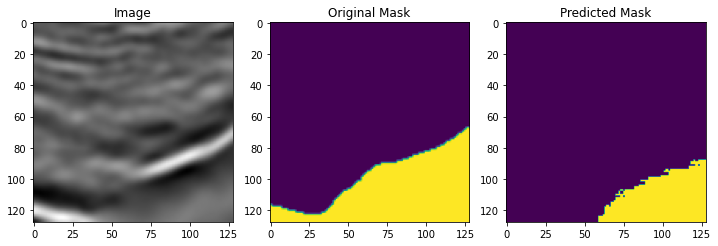

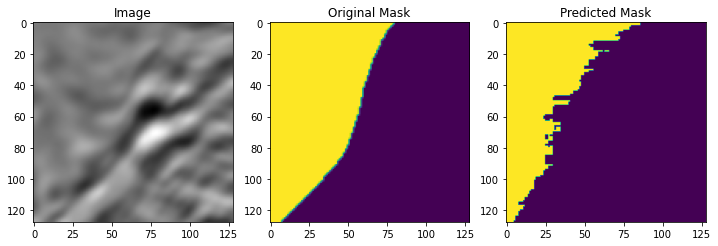

In [8]:
print("[INFO] loading up test image paths...")
imagePaths = open(config.TEST_PATHS).read().strip().split('\n') #use defined address in train.ipynb
imagePaths = np.random.choice(imagePaths, size = 10) #select 10 ramdom element in imagePathList!

print("[INFO] load up model...")

# load latest model name from output/model_names.txt
f = open(config.MODEL_PATH, 'r')
lines = f.readlines()
f.close()
recent_model_path = lines[-1].strip()
print(recent_model_path)

unet = torch.load(recent_model_path).to(config.DEVICE)

for path in imagePaths:
    make_prediction(unet, path)